In [1]:
# this version accepts all images, both good and bad, the bad ones have labels -1, -1
# this notebook has just quick CNN training
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
tf.__version__

'1.11.0'

In [3]:
img_data = np.load('all_img_data.npy')
img_data.shape

(21852, 64, 64)

In [4]:
lab_data1 = np.load('char1_labels.npy')
lab_data1 += 1 # to shift the -1 labels
print(lab_data1.shape)

(21852,)


In [5]:
lab_data2 = np.load('char2_labels.npy')
lab_data2 += 1
print(lab_data2.shape)

(21852,)


In [6]:
#goodness_data = np.load('goodness_labels.npy')
#goodness_data.shape

In [7]:
#tst1 = np.histogram(lab_data1, bins=25)
#print(tst1)
#tst2 = np.histogram(lab_data2, bins=25)
#print(tst2)

In [8]:
assert(lab_data1.shape[0] == img_data.shape[0] and lab_data1.shape[0] == lab_data2.shape[0])

In [9]:
def vis_data(offset):
   plt.figure(figsize=(10,10))
   for i in range(6*6):
       plt.subplot(6,6,i+1)
       plt.xticks([])
       plt.yticks([])
       plt.grid(False)
       plt.imshow(img_data[offset + i], cmap=plt.cm.gray)
       plt.xlabel(str(lab_data1[offset + i]) + ", " + str(lab_data2[offset + i])) 

In [10]:
# visualize some of the data
#vis_data(0)

In [11]:
# random shuffle to randomly split between test/train samples
total_samples = lab_data1.shape[0]
print(total_samples)
ind_list = [i for i in range(total_samples)]
np.random.shuffle(ind_list)
img_data = img_data[ind_list, :, :]
lab_data1 = lab_data1[ind_list]
lab_data2 = lab_data2[ind_list]
#goodness_data = goodness_data[ind_list]

21852


In [12]:
# visualize some of the data after shuffling
#vis_data(0)

In [13]:
train_samples = 20000
assert(train_samples < total_samples)
test_samples = total_samples - train_samples
train_images = img_data[:train_samples, :, :]
train_labels1 = lab_data1[:train_samples]
train_labels2 = lab_data2[:train_samples]
#train_goodness = goodness_data[:train_samples]

test_images = img_data[train_samples:total_samples, :]
test_labels1 = lab_data1[train_samples:total_samples]
test_labels2 = lab_data2[train_samples:total_samples]
#test_goodness = goodness_data[train_samples:total_samples]

In [14]:
train_images.shape, train_labels1.shape, train_labels2.shape

((20000, 64, 64), (20000,), (20000,))

In [15]:
test_images.shape, test_labels1.shape, test_labels2.shape

((1852, 64, 64), (1852,), (1852,))

In [16]:
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1) / 255
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1) / 255

In [17]:
np.min(train_images), np.max(train_images)

(0.0, 1.0)

In [18]:
train_images.shape, test_images.shape

((20000, 64, 64, 1), (1852, 64, 64, 1))

In [19]:
np.histogram(test_labels1, bins=25)

(array([1567,    4,   14,   15,   13,   19,   16,   16,    6,    6,   16,
           5,   19,   10,    7,    8,   13,   27,   12,    5,    4,   11,
          11,   10,   18], dtype=int64),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]))

In [20]:
#sess.close()

In [21]:
#define compute graph in tensorflow to evaluate the cost function
tf.reset_default_graph()
rseed2 = 123
np.random.seed(rseed2)
tf.set_random_seed(rseed2)
imgs_ph = tf.placeholder(tf.float32, [None, 64, 64, 1])
labels1_ph = tf.placeholder(tf.int32, [None])
labels2_ph = tf.placeholder(tf.int32, [None])
learnrate_ph = tf.placeholder(tf.float32, None)
training_ph = tf.placeholder(tf.bool)
pkeep_ph = tf.placeholder(tf.float32)

In [22]:
# initialize variables for...
# ... 1) convolution kernels
num_classes = 26

num_filters1 = 12
num_filters2 = 25
num_filters3 = 50
W1 = tf.get_variable("W1", shape=[5, 5, 1, num_filters1], initializer=tf.initializers.glorot_normal())
b1 = tf.get_variable("b1", shape=[num_filters1], initializer=tf.initializers.zeros())
W2 = tf.get_variable("W2", shape=[5, 5, num_filters1, num_filters2], initializer=tf.initializers.glorot_normal())
b2 = tf.get_variable("b2", shape=[num_filters2], initializer=tf.initializers.zeros())
W3 = tf.get_variable("W3", shape=[5, 5, num_filters2, num_filters3], initializer=tf.initializers.glorot_normal())
b3 = tf.get_variable("b3", shape=[num_filters3], initializer=tf.initializers.zeros())

num_fc1 = 800
num_fc2 = 120
num_fc3 = 80
num_fc4 = 50
# ... 2) dense layers: fork 1 (first character prediction)
W4a = tf.get_variable("W4a", shape=[num_fc1, num_fc2], initializer=tf.initializers.glorot_normal())
b4a = tf.get_variable("b4a", shape=[num_fc2], initializer=tf.initializers.zeros())
W5a = tf.get_variable("W5a", shape=[num_fc2, num_fc3], initializer=tf.initializers.glorot_normal())
b5a = tf.get_variable("b5a", shape=[num_fc3], initializer=tf.initializers.zeros())
W6a = tf.get_variable("W6a", shape=[num_fc3, num_fc4], initializer=tf.initializers.glorot_normal())
b6a = tf.get_variable("b6a", shape=[num_fc4], initializer=tf.initializers.zeros())
W7a = tf.get_variable("W7a", shape=[num_fc4, num_classes], initializer=tf.initializers.glorot_normal())
b7a = tf.get_variable("b7a", shape=[num_classes], initializer=tf.initializers.zeros())
# ... 3) dense layers: fork 2 (second character prediction)
W4b = tf.get_variable("W4b", shape=[num_fc1, num_fc2], initializer=tf.initializers.glorot_normal())
b4b = tf.get_variable("b4b", shape=[num_fc2], initializer=tf.initializers.zeros())
W5b = tf.get_variable("W5b", shape=[num_fc2, num_fc3], initializer=tf.initializers.glorot_normal())
b5b = tf.get_variable("b5b", shape=[num_fc3], initializer=tf.initializers.zeros())
W6b = tf.get_variable("W6b", shape=[num_fc3, num_fc4], initializer=tf.initializers.glorot_normal())
b6b = tf.get_variable("b6b", shape=[num_fc4], initializer=tf.initializers.zeros())
# note the num_classes - 1 below:
W7b = tf.get_variable("W7b", shape=[num_fc4, num_classes - 1], initializer=tf.initializers.glorot_normal())
b7b = tf.get_variable("b7b", shape=[num_classes - 1], initializer=tf.initializers.zeros())
#W4c = tf.get_variable("W4c", shape=[num_fc1, num_fc2], initializer=tf.initializers.glorot_normal())
#b4c = tf.get_variable("b4c", shape=[num_fc2], initializer=tf.initializers.zeros())
#W5c = tf.get_variable("W5c", shape=[num_fc2, num_fc3], initializer=tf.initializers.glorot_normal())
#b5c = tf.get_variable("b5c", shape=[num_fc3], initializer=tf.initializers.zeros())
#W6c = tf.get_variable("W6c", shape=[num_fc3, num_fc4], initializer=tf.initializers.glorot_normal())
#b6c = tf.get_variable("b6c", shape=[num_fc4], initializer=tf.initializers.zeros())
#W7c = tf.get_variable("W7c", shape=[num_fc4, 1], initializer=tf.initializers.glorot_normal())
#b7c = tf.get_variable("b7c", shape=[1], initializer=tf.initializers.zeros())

In [23]:
assert(num_classes == max(lab_data1) + 1)

In [24]:
# build compute graph evaluating the CNN
conv1 = tf.nn.relu(tf.layers.batch_normalization(tf.nn.conv2d(imgs_ph, W1, strides = [1,1,1,1], padding = 'VALID'), 
                                                 axis=[1,2,3], training=training_ph))
#conv1 = tf.nn.relu(tf.nn.conv2d(imgs_ph, W1, strides = [1,1,1,1], padding = 'VALID'))
pool1 = tf.nn.dropout(tf.nn.max_pool(conv1, ksize = [1,2,2,1], strides=[1,2,2,1], padding = 'VALID'), pkeep_ph)
conv2 = tf.nn.relu(tf.layers.batch_normalization(tf.nn.conv2d(pool1, W2, strides = [1,1,1,1], padding = 'VALID'), 
                                                 axis=[1,2,3], training=training_ph))
#conv2 = tf.nn.relu(tf.nn.conv2d(pool1, W2, strides = [1,1,1,1], padding = 'VALID'))
pool2 = tf.nn.dropout(tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides=[1,2,2,1], padding = 'VALID'), pkeep_ph)
conv3 = tf.nn.relu(tf.layers.batch_normalization(tf.nn.conv2d(pool2, W3, strides = [1,1,1,1], padding = 'VALID'), 
                                                 axis=[1,2,3], training=training_ph))
#conv3 = tf.nn.relu(tf.nn.conv2d(pool2, W3, strides = [1,1,1,1], padding = 'VALID'))
pool3 = tf.nn.dropout(tf.nn.max_pool(conv3, ksize = [1,2,2,1], strides=[1,2,2,1], padding = 'VALID'), pkeep_ph)
flat1 = tf.reshape(pool3, [-1, num_fc1])
bnorm_axis = -1
dens1a = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(flat1, W4a), axis=bnorm_axis, training=training_ph)), pkeep_ph)
dens2a = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(dens1a, W5a), axis=bnorm_axis, training=training_ph)), pkeep_ph)
dens3a = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(dens2a, W6a), axis=bnorm_axis, training=training_ph)), 1.0)
dens4a = tf.layers.batch_normalization(tf.matmul(dens3a, W7a), axis=bnorm_axis, training=training_ph)

dens1b = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(flat1, W4b), axis=bnorm_axis, training=training_ph)), pkeep_ph)
dens2b = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(dens1b, W5b), axis=bnorm_axis, training=training_ph)), pkeep_ph)
dens3b = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(dens2b, W6b), axis=bnorm_axis, training=training_ph)), 1.0)
dens4b_partial = tf.layers.batch_normalization(tf.matmul(dens3b, W7b), axis=bnorm_axis, training=training_ph)
# hack: copy the first column of dens4a into dens4b
d4a_s1, d4a_s2 = tf.split(dens4a, [1,25], 1)
dens4b = tf.concat([d4a_s1, dens4b_partial], axis=1)

#crent = tf.nn.sigmoid_cross_entropy_with_logits(labels = goodness_ph, logits = dens4c)
crenta = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels1_ph, logits = dens4a)
crentb = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels2_ph, logits = dens4b)
crent = crenta + crentb
loss_fun = tf.reduce_mean(crent)
# for batch-norm updates:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate = learnrate_ph).minimize(loss_fun)

predictions1 = tf.equal(tf.argmax(dens4a, 1), tf.cast(labels1_ph, tf.int64))
predictions2 = tf.equal(tf.argmax(dens4b, 1), tf.cast(labels2_ph, tf.int64))
predictions = tf.logical_and(predictions1, predictions2)
accuracy = tf.reduce_mean(tf.cast(predictions, tf.float32))
#predictions_goodness = tf.math.greater(dens4c, 0.0)
#correct_preds_g = tf.equal(predictions_goodness, tf.cast(goodness_ph, tf.bool))
#accuracy = tf.reduce_mean(tf.cast(correct_preds_g, tf.float32))

In [25]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [26]:
batch_size = 400
learning_rate = 0.001
num_batches = int(train_images.shape[0] / batch_size)
print('num_batches =', num_batches)
# discard training data that overflow the last minibatch
trunc_train_images = train_images[:num_batches*batch_size,:,:,:]
trunc_train_labels1 = train_labels1[:num_batches*batch_size]
trunc_train_labels2 = train_labels2[:num_batches*batch_size]
#trunc_train_goodness = train_goodness[:num_batches*batch_size]

num_batches = 50


In [27]:
def train(num_epochs, learning_rate = 0.001, pkeep = 0.75):
    global trunc_train_images, trunc_train_labels1, trunc_train_labels2
    for e in range(num_epochs):
        # randomize the order of training data
        ind_list = [i for i in range(trunc_train_images.shape[0])]
        np.random.shuffle(ind_list)
        trunc_train_images = trunc_train_images[ind_list, :, :, :]
        trunc_train_labels1 = trunc_train_labels1[ind_list]
        trunc_train_labels2 = trunc_train_labels2[ind_list]
        #trunc_train_goodness = trunc_train_goodness[ind_list]

        start_time = time.time()
        for i in range(num_batches):        
            train_dict = {imgs_ph:trunc_train_images[i*batch_size:(i+1)*batch_size,:,:,:], 
                          labels1_ph:trunc_train_labels1[i*batch_size:(i+1)*batch_size],
                          labels2_ph:trunc_train_labels2[i*batch_size:(i+1)*batch_size],
                          learnrate_ph:learning_rate,
                          training_ph:True,
                          pkeep_ph:pkeep}                          
            sess.run(train_step, train_dict)
            #print(e, '/', i)
            # the following stats compute can be removed to speed up training
            #mb_loss, mb_acc = sess.run([loss_fun, accuracy], train_dict)    
            #print(e, '/', i, ': mb_loss = ', mb_loss, ' mb_acc = ', mb_acc)

        loss_train, acc_train = 0.0, 0.0
        for i in range(num_batches):    
            train_dict = {imgs_ph:trunc_train_images[i*batch_size:(i+1)*batch_size,:,:,:], 
                          labels1_ph:trunc_train_labels1[i*batch_size:(i+1)*batch_size],
                          labels2_ph:trunc_train_labels2[i*batch_size:(i+1)*batch_size],
                          learnrate_ph:learning_rate,
                          training_ph:False, pkeep_ph:1.0}
            l_train, a_train = sess.run([loss_fun, accuracy], train_dict)    
            loss_train += l_train
            acc_train += a_train
        end_time = time.time()
        elaps_time = end_time - start_time

        loss_train /= num_batches
        acc_train /= num_batches

        # also compute loss & accuracy on the test set, no need to minibatch that 
        loss_test, acc_test = sess.run([loss_fun, accuracy], {imgs_ph:test_images, labels1_ph:test_labels1, labels2_ph:test_labels2, learnrate_ph:learning_rate, training_ph:False, pkeep_ph:1.0})

        print("%03i (%.2f): ltr = %.6f, atr = %.6f | lts = %.6f, ats = %.6f" % (e, elaps_time, loss_train, acc_train, loss_test, acc_test))
        #print(e, ': loss_train =', loss_train, ' acc_train =', acc_train, 'time =', end_time - start_time)

In [28]:
train(1000)

000 (8.63): ltr = 5.621026, atr = 0.852000 | lts = 5.628729, ats = 0.846112
001 (5.35): ltr = 4.859930, atr = 0.851950 | lts = 4.873908, ats = 0.846112
002 (5.37): ltr = 4.639712, atr = 0.848700 | lts = 4.658436, ats = 0.841253
003 (5.18): ltr = 4.429960, atr = 0.851750 | lts = 4.449360, ats = 0.845572
004 (5.34): ltr = 4.226421, atr = 0.855550 | lts = 4.251732, ats = 0.845572
005 (5.49): ltr = 3.923540, atr = 0.879600 | lts = 3.956815, ats = 0.868791
006 (5.30): ltr = 3.623845, atr = 0.903600 | lts = 3.660260, ats = 0.889849
007 (5.29): ltr = 3.389001, atr = 0.919300 | lts = 3.416684, ats = 0.907127
008 (5.38): ltr = 3.077504, atr = 0.938950 | lts = 3.109740, ats = 0.931426
009 (5.43): ltr = 2.820255, atr = 0.942900 | lts = 2.860352, ats = 0.938985
010 (5.18): ltr = 2.623225, atr = 0.955650 | lts = 2.669875, ats = 0.943844
011 (5.18): ltr = 2.444773, atr = 0.965150 | lts = 2.477083, ats = 0.961663
012 (5.17): ltr = 2.293153, atr = 0.961450 | lts = 2.336442, ats = 0.958423
013 (5.18): 

108 (5.18): ltr = 0.034225, atr = 0.999150 | lts = 0.129009, ats = 0.988121
109 (5.19): ltr = 0.041485, atr = 0.997600 | lts = 0.138973, ats = 0.988661
110 (5.17): ltr = 0.321250, atr = 0.958550 | lts = 0.437806, ats = 0.941685
111 (5.17): ltr = 0.035525, atr = 0.998800 | lts = 0.120131, ats = 0.988661
112 (5.17): ltr = 0.039296, atr = 0.998350 | lts = 0.137505, ats = 0.988121
113 (5.18): ltr = 0.086269, atr = 0.991350 | lts = 0.188848, ats = 0.982181
114 (5.18): ltr = 0.033243, atr = 0.999050 | lts = 0.148814, ats = 0.988121
115 (5.18): ltr = 0.034699, atr = 0.997350 | lts = 0.132524, ats = 0.988121
116 (5.16): ltr = 0.026785, atr = 0.999000 | lts = 0.133859, ats = 0.987581
117 (5.19): ltr = 0.051704, atr = 0.993550 | lts = 0.152358, ats = 0.980022
118 (5.18): ltr = 0.054515, atr = 0.993650 | lts = 0.164493, ats = 0.980562
119 (5.18): ltr = 0.036977, atr = 0.996550 | lts = 0.125812, ats = 0.986501
120 (5.18): ltr = 0.029296, atr = 0.998900 | lts = 0.128808, ats = 0.989201
121 (5.17): 

216 (5.20): ltr = 0.075805, atr = 0.988350 | lts = 0.198109, ats = 0.977322
217 (5.18): ltr = 0.008488, atr = 0.998850 | lts = 0.115241, ats = 0.987581
218 (5.17): ltr = 0.044648, atr = 0.991650 | lts = 0.145015, ats = 0.980562
219 (5.19): ltr = 0.005182, atr = 0.999400 | lts = 0.111289, ats = 0.988661
220 (5.17): ltr = 0.048004, atr = 0.991600 | lts = 0.159240, ats = 0.978402
221 (5.21): ltr = 0.010294, atr = 0.998100 | lts = 0.102514, ats = 0.987581
222 (5.18): ltr = 0.052614, atr = 0.989600 | lts = 0.156726, ats = 0.981641
223 (5.16): ltr = 0.002923, atr = 0.999850 | lts = 0.103095, ats = 0.991361
224 (5.17): ltr = 0.222409, atr = 0.965850 | lts = 0.348736, ats = 0.953564
225 (5.17): ltr = 0.005182, atr = 0.999250 | lts = 0.107439, ats = 0.987041
226 (5.17): ltr = 0.003218, atr = 0.999700 | lts = 0.123895, ats = 0.989201
227 (5.16): ltr = 0.003550, atr = 0.999650 | lts = 0.121538, ats = 0.990281
228 (5.18): ltr = 0.009113, atr = 0.998500 | lts = 0.127815, ats = 0.987041
229 (5.18): 

324 (5.19): ltr = 0.008208, atr = 0.998300 | lts = 0.126734, ats = 0.985421
325 (5.19): ltr = 0.007771, atr = 0.998150 | lts = 0.130427, ats = 0.987041
326 (5.18): ltr = 0.000794, atr = 0.999950 | lts = 0.130845, ats = 0.988661
327 (5.17): ltr = 0.024357, atr = 0.994350 | lts = 0.143234, ats = 0.981102
328 (5.18): ltr = 0.001380, atr = 0.999600 | lts = 0.121286, ats = 0.987581
329 (5.19): ltr = 0.500378, atr = 0.947150 | lts = 0.653465, ats = 0.933585
330 (5.17): ltr = 0.001123, atr = 0.999850 | lts = 0.103602, ats = 0.991361
331 (5.19): ltr = 0.027550, atr = 0.995750 | lts = 0.149096, ats = 0.986501
332 (5.20): ltr = 0.002113, atr = 0.999600 | lts = 0.129203, ats = 0.987041
333 (5.19): ltr = 0.000809, atr = 0.999900 | lts = 0.129149, ats = 0.991361
334 (5.19): ltr = 0.007306, atr = 0.998000 | lts = 0.126450, ats = 0.987581
335 (5.17): ltr = 0.031019, atr = 0.993850 | lts = 0.163235, ats = 0.984341
336 (5.17): ltr = 0.002294, atr = 0.999550 | lts = 0.106735, ats = 0.989741
337 (5.19): 

KeyboardInterrupt: 

In [29]:
train(4000, 0.0003)

000 (5.29): ltr = 0.000625, atr = 0.999950 | lts = 0.106928, ats = 0.989741
001 (5.30): ltr = 0.000655, atr = 0.999850 | lts = 0.105830, ats = 0.991901
002 (5.40): ltr = 0.000465, atr = 1.000000 | lts = 0.115548, ats = 0.992981
003 (5.19): ltr = 0.000593, atr = 0.999900 | lts = 0.114729, ats = 0.990281
004 (5.18): ltr = 0.000465, atr = 1.000000 | lts = 0.113544, ats = 0.992441
005 (5.19): ltr = 0.000412, atr = 0.999950 | lts = 0.113017, ats = 0.992441
006 (5.17): ltr = 0.000826, atr = 0.999900 | lts = 0.113675, ats = 0.989741
007 (5.18): ltr = 0.000627, atr = 0.999950 | lts = 0.102436, ats = 0.991361
008 (5.18): ltr = 0.002939, atr = 0.999350 | lts = 0.100876, ats = 0.989741
009 (5.18): ltr = 0.000674, atr = 0.999900 | lts = 0.119110, ats = 0.988121
010 (5.19): ltr = 0.000384, atr = 0.999950 | lts = 0.107862, ats = 0.990281
011 (5.17): ltr = 0.000379, atr = 1.000000 | lts = 0.099998, ats = 0.991901
012 (5.18): ltr = 0.001310, atr = 0.999850 | lts = 0.117453, ats = 0.988121
013 (5.18): 

108 (5.18): ltr = 0.000234, atr = 1.000000 | lts = 0.105179, ats = 0.991901
109 (5.17): ltr = 0.000306, atr = 1.000000 | lts = 0.117682, ats = 0.991361
110 (5.21): ltr = 0.000253, atr = 1.000000 | lts = 0.116886, ats = 0.990821
111 (5.21): ltr = 0.000246, atr = 1.000000 | lts = 0.108990, ats = 0.990821
112 (5.19): ltr = 0.000249, atr = 1.000000 | lts = 0.132469, ats = 0.990821
113 (5.19): ltr = 0.000385, atr = 0.999950 | lts = 0.109255, ats = 0.990821
114 (5.18): ltr = 0.000228, atr = 1.000000 | lts = 0.120474, ats = 0.991901
115 (5.20): ltr = 0.000221, atr = 1.000000 | lts = 0.108879, ats = 0.991361
116 (5.20): ltr = 0.000276, atr = 1.000000 | lts = 0.098459, ats = 0.990281
117 (5.19): ltr = 0.000298, atr = 0.999950 | lts = 0.111084, ats = 0.990281
118 (5.19): ltr = 0.002476, atr = 0.999550 | lts = 0.102155, ats = 0.990281
119 (5.21): ltr = 0.018276, atr = 0.996200 | lts = 0.129638, ats = 0.987581
120 (5.18): ltr = 0.000257, atr = 1.000000 | lts = 0.128976, ats = 0.991361
121 (5.18): 

KeyboardInterrupt: 

In [ ]:
#train(10, 0.0001)

In [ ]:
#train(40, 0.0003)

In [ ]:
# next double check if the test accuracy is correct:

In [30]:
t_dens4a = sess.run(dens4a, {imgs_ph:test_images, labels1_ph:test_labels1, labels2_ph:test_labels1, training_ph:False, pkeep_ph:1.0})

In [31]:
t_predictions1 = np.argmax(t_dens4a, 1)

In [32]:
t_predictions1.shape, test_images.shape[0]

((1852,), 1852)

In [33]:
t_dens4b = sess.run(dens4b, {imgs_ph:test_images, labels1_ph:test_labels1, labels2_ph:test_labels1, training_ph:False, pkeep_ph:1.0})

In [34]:
t_predictions2 = np.argmax(t_dens4b, 1)

In [35]:
t_predictions2

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [36]:
count = 0
for i in range(test_images.shape[0]):    
    if t_predictions1[i] == test_labels1[i] and t_predictions2[i] == test_labels2[i]:
        count = count + 1
print(float(count) / test_images.shape[0])

0.9924406047516199


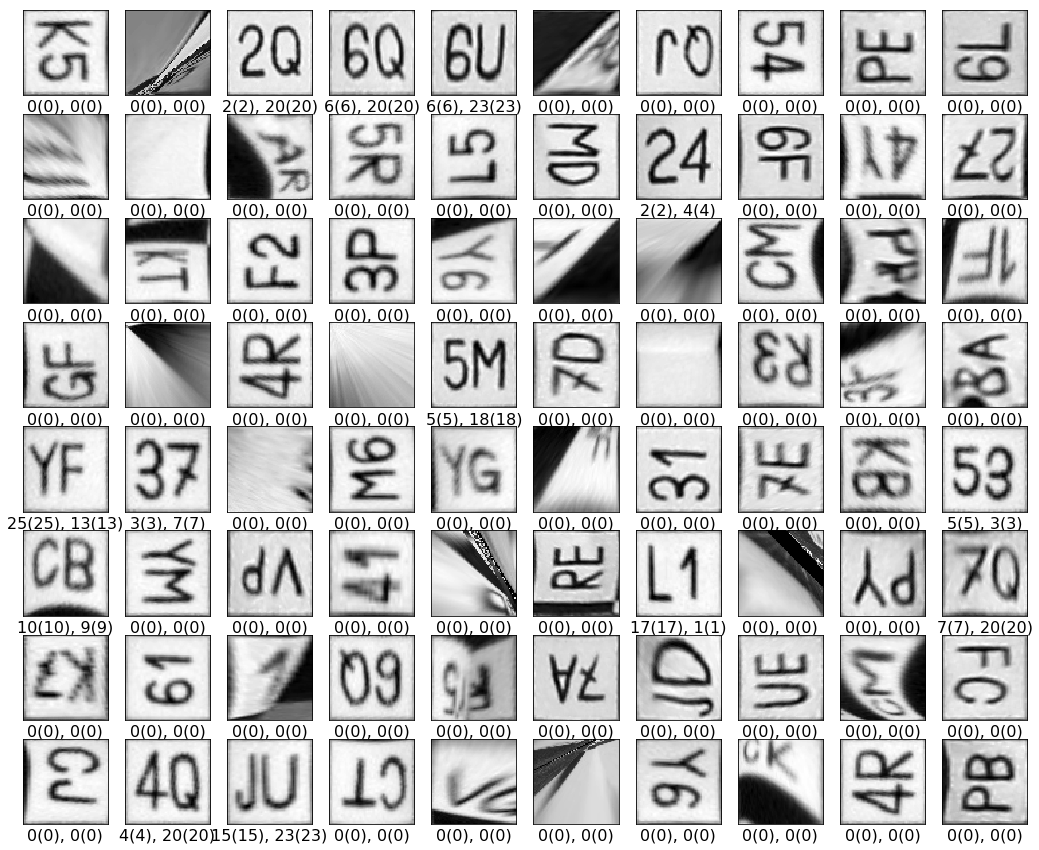

In [37]:
# visualize the predictions
offset = 80
plt.figure(figsize=(18,15))
for i in range(10*8):
    plt.subplot(8,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)    
    plt.imshow(test_images[offset + i, :, :, 0], cmap=plt.cm.gray)
    #plt.xlabel(str(t_predictions1[offset + i]) + ", " + str(t_predictions2[offset + i])) 
    plt.xlabel("%i(%i), %i(%i)" % (t_predictions1[offset + i], test_labels1[offset + i],
                                   t_predictions2[offset + i], test_labels2[offset + i]), fontsize = 16)

In [38]:
# select incorrect predictions
err_imgs = []
err_str = []
for i in range(test_images.shape[0]):    
    if t_predictions1[i] == test_labels1[i] and t_predictions2[i] == test_labels2[i]:
        None
    else:
        err_imgs.append(test_images[i, :, :, 0])
        err_str.append("%i(%i), %i(%i)" % (t_predictions1[i], test_labels1[i], t_predictions2[i], test_labels2[i]))
print(len(err_imgs))

14


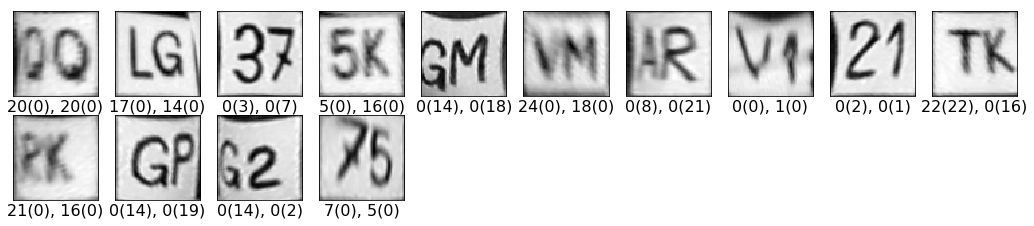

In [39]:
# visualize them
plt.figure(figsize=(18,15))
for i in range(len(err_imgs)):
    plt.subplot(8,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)    
    plt.imshow(err_imgs[i], cmap=plt.cm.gray)    
    plt.xlabel(err_str[i], fontsize = 16)

In [40]:
saver = tf.train.Saver()
save_path = saver.save(sess, ".\CNN_2char_bn_unified.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: .\CNN_2char_bn_unified.ckpt


In [41]:
sess.close()